In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os, sys
from collections import Counter

In [2]:
!pip install verstack

  Created wheel for verstack: filename=verstack-0.3.1-cp36-none-any.whl size=14343 sha256=64c13ac5fbe9b9b0231012bff0212c6b08072eaa66d142c6dd313a5b0d5df0a7
  Stored in directory: /root/.cache/pip/wheels/15/1b/58/10e59516150cea4d9b1dbacceb3bffcc0cfd2d166efabec2f6
Successfully built verstack


In [3]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
path_data = "/content/gdrive/MyDrive/DataSets"
path_data_train = path_data + "/train.csv"
path_data_train

'/content/gdrive/MyDrive/DataSets/train.csv'

In [6]:
train = pd.read_csv(path_data_train)
train.columns

Index(['id', 'timestamp', 'retweet_count', 'user_verified',
       'user_statuses_count', 'user_followers_count', 'user_friends_count',
       'user_mentions', 'urls', 'hashtags', 'text'],
      dtype='object')

In [7]:
sorted_csv = train.sort_values(by=["retweet_count"], ascending=False)
sorted_csv.drop('timestamp', axis=1, inplace=True)

In [8]:
sorted_csv[20:23]

,id,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text
408817,408817,185406,False,86803,1238,99,NaN,NaN,NaN,when the coronavirus tweets are funny but ur s...
470317,470317,178111,False,876,5361,4292,NaN,NaN,NaN,My dog after I sent him to get supplies since ...
535135,535135,168249,True,142957,138422,11082,NaN,NaN,NaN,In retrospect Sandy Hook marked the end of the...


In [10]:
counter_user_mentions = sorted_csv['user_mentions'].isnull().sum()
counter_urls = sorted_csv['urls'].isnull().sum()
counter_hashtags = sorted_csv['hashtags'].isnull().sum()

print("\t User_mentions column NULL entries: ", counter_user_mentions)
print("\t Urls column column NULL entries: ", counter_urls)
print("\t Hashtags column NULL entries: ", counter_hashtags)
print("\t Number of row: ", len(sorted_csv.index))

	 User_mentions column NULL entries:  611486
	 Urls column column NULL entries:  451697
	 Hashtags column NULL entries:  593326
	 Number of row:  665777


In [ ]:
'''
Attention
As noted in the previous cell, we can drop the columns since most of the entries does not provide much information

In [12]:
sorted_csv.drop('user_mentions', axis=1, inplace=True)
sorted_csv.drop('urls', axis=1, inplace=True)
sorted_csv.drop('hashtags', axis=1, inplace=True)

In [13]:
sorted_csv[:5]

,id,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,text
546442,546442,942572,True,12256,25441659,133,Never Not 💜 https://t.co/Ag9oUTJvrN
565532,565532,647993,True,11599,27641492,824,To all the little girls watching...never doubt...
225845,225845,636394,True,12256,25441494,133,☺ https://t.co/9vNeJtA1vW
117825,117825,415787,False,1956,14783,1530,Easily one of the best social distancing ads I...
622524,622524,334427,True,4622,5313436,26,"I can’t believe I have to say this, but please..."


In [14]:
sorted_csv.describe()

,id,retweet_count,user_statuses_count,user_followers_count,user_friends_count
count,665777.000000,665777.000000,6.657770e+05,6.657770e+05,6.657770e+05
mean,332888.000000,147.687398,4.167295e+04,2.329881e+05,2.743131e+03
std,192193.409422,2972.051181,9.848516e+04,2.442260e+06,1.725410e+04
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,166444.000000,0.000000,2.352000e+03,2.060000e+02,2.290000e+02
50%,332888.000000,0.000000,1.080400e+04,1.002000e+03,6.390000e+02
75%,499332.000000,2.000000,3.809900e+04,6.012000e+03,1.746000e+03
max,665776.000000,942572.000000,7.203222e+06,1.170640e+08,4.399078e+06


# 1. Setting Up


In [15]:
# keras.datasets.imdb is broken in TensorFlow 1.13 and 1.14 due to numpy 1.16.3
!pip install numpy==1.16.2

# All the imports!
import tensorflow as tf 
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import sequence
from numpy import array

from keras_preprocessing.text import Tokenizer

# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True

     |████████████████████████████████| 17.3MB 212kB/s 
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [16]:
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist 
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Create Mapping

Reviews in the IMDB dataset have been encoded as a sequence of integers. Luckily the dataset also contains an index for converting the reviews back into human readable form.

# Data Insight


Here we take a closer look at our data. How many words do our tweets contain?

In [17]:
path_data = "/content/gdrive/MyDrive/DataSets"
path_data_train = path_data + "/train.csv"
train = pd.read_csv(path_data_train)
train.columns

Index(['id', 'timestamp', 'retweet_count', 'user_verified',
       'user_statuses_count', 'user_followers_count', 'user_friends_count',
       'user_mentions', 'urls', 'hashtags', 'text'],
      dtype='object')

In [18]:
train.shape

(665777, 11)

In [19]:
train_data_new = train[["id", "retweet_count", "text"]]
train_data_new[4555:4558]

,id,retweet_count,text
4555,4555,0,Correct.. this cooking of figures must fall
4556,4556,1,Listen to a leader and act like a leader @Just...
4557,4557,13,I love this song https://t.co/k6ytWiWo9Q


In [20]:
type(train_data_new)

pandas.core.frame.DataFrame

In [21]:
x = []
y = []
for index, row in train_data_new.iterrows():
  if(row["retweet_count"] > 0):
    x.append(row[2])
    y.append(row[1])

In [ ]:
len(y)

242974

In [22]:
train_data_new = pd.DataFrame({'retweet_count': y, 'text': x}, columns=['retweet_count', 'text'])

In [23]:
train_data_new["retweet_count"][4232]

2

In [24]:
tweet_length = 100
x_train = train_data_new.copy(deep='true')
print("Shape Training Tweet Data: " + str(x_train.shape))
print("Maximum Tweet length: {}".format(len(max((train_data_new.text), key=len))))
print("Minimum Tweet length: {}".format(len(min((train_data_new.text), key=len))))
result = [len(x) for x in train_data_new]
print("Mean Tweet length: {}".format(np.mean(result)))

Shape Training Tweet Data: (242974, 2)
Maximum Tweet length: 987
Minimum Tweet length: 1
Mean Tweet length: 8.5


# Pre-Processing


We need to make sure that our reviews are of a uniform length. This is for the LSTM's parameters.

Some reviews will need to be truncated, while others need to be padded.

In [25]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.
import re, string
from verstack.stratified_continuous_split import scsplit

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [26]:
train_data_new['text'] = train_data_new['text'].apply(lambda x: remove_URL(x))
train_data_new['text'] = train_data_new['text'].apply(lambda x: remove_emoji(x))
train_data_new['text'] = train_data_new['text'].apply(lambda x: remove_html(x))
train_data_new['text'] = train_data_new['text'].apply(lambda x: remove_punct(x))
train_data_new.sample(5)

,retweet_count,text
215626,3,The coronavirus is having a huge impact on our...
180173,1,Excellent piece by amyyqin and co at the NYT a...
207777,210,Shri RahulGandhi ji will be interacting with t...
74271,1,NYCMayor worldflood1 About that our friends ac...
218200,973,As a survivor myself I believe JoeBiden\n\nRea...


In [27]:
# tokenizing
train_data_new['tokenized'] = train_data_new['text'].apply(word_tokenize)
train_data_new.head()

,retweet_count,text,tokenized
0,2,Extremely valid points being made here Ethiop...,"[Extremely, valid, points, being, made, here, ..."
1,1,COVID19 dominated the discussion Tuesday at a ...,"[COVID19, dominated, the, discussion, Tuesday,..."
2,2,Man Caught With Pipe Bombs Was Planning Armed ...,"[Man, Caught, With, Pipe, Bombs, Was, Planning..."
3,5,Quarantine measures imposed as a response to t...,"[Quarantine, measures, imposed, as, a, respons..."
4,2,Why does Superstitious times Stupid always equ...,"[Why, does, Superstitious, times, Stupid, alwa..."


In [28]:
#lower case
train_data_new['lower'] = train_data_new['tokenized'].apply(lambda x: [word.lower() for word in x])
train_data_new.head()

,retweet_count,text,tokenized,lower
0,2,Extremely valid points being made here Ethiop...,"[Extremely, valid, points, being, made, here, ...","[extremely, valid, points, being, made, here, ..."
1,1,COVID19 dominated the discussion Tuesday at a ...,"[COVID19, dominated, the, discussion, Tuesday,...","[covid19, dominated, the, discussion, tuesday,..."
2,2,Man Caught With Pipe Bombs Was Planning Armed ...,"[Man, Caught, With, Pipe, Bombs, Was, Planning...","[man, caught, with, pipe, bombs, was, planning..."
3,5,Quarantine measures imposed as a response to t...,"[Quarantine, measures, imposed, as, a, respons...","[quarantine, measures, imposed, as, a, respons..."
4,2,Why does Superstitious times Stupid always equ...,"[Why, does, Superstitious, times, Stupid, alwa...","[why, does, superstitious, times, stupid, alwa..."


In [29]:
#removing stopwords
stop = set(stopwords.words('english'))
train_data_new['stopwords_removed'] = train_data_new['lower'].apply(lambda x: [word for word in x if word not in stop])
train_data_new.head()

,retweet_count,text,tokenized,lower,stopwords_removed
0,2,Extremely valid points being made here Ethiop...,"[Extremely, valid, points, being, made, here, ...","[extremely, valid, points, being, made, here, ...","[extremely, valid, points, made, ethiopia, gre..."
1,1,COVID19 dominated the discussion Tuesday at a ...,"[COVID19, dominated, the, discussion, Tuesday,...","[covid19, dominated, the, discussion, tuesday,...","[covid19, dominated, discussion, tuesday, meet..."
2,2,Man Caught With Pipe Bombs Was Planning Armed ...,"[Man, Caught, With, Pipe, Bombs, Was, Planning...","[man, caught, with, pipe, bombs, was, planning...","[man, caught, pipe, bombs, planning, armed, pr..."
3,5,Quarantine measures imposed as a response to t...,"[Quarantine, measures, imposed, as, a, respons...","[quarantine, measures, imposed, as, a, respons...","[quarantine, measures, imposed, response, covi..."
4,2,Why does Superstitious times Stupid always equ...,"[Why, does, Superstitious, times, Stupid, alwa...","[why, does, superstitious, times, stupid, alwa...","[superstitious, times, stupid, always, equal, ..."


In [30]:
train_data_new['pos_tags'] = train_data_new['stopwords_removed'].apply(nltk.tag.pos_tag)
train_data_new.head()

,retweet_count,text,tokenized,lower,stopwords_removed,pos_tags
0,2,Extremely valid points being made here Ethiop...,"[Extremely, valid, points, being, made, here, ...","[extremely, valid, points, being, made, here, ...","[extremely, valid, points, made, ethiopia, gre...","[(extremely, RB), (valid, JJ), (points, NNS), ..."
1,1,COVID19 dominated the discussion Tuesday at a ...,"[COVID19, dominated, the, discussion, Tuesday,...","[covid19, dominated, the, discussion, tuesday,...","[covid19, dominated, discussion, tuesday, meet...","[(covid19, NN), (dominated, VBN), (discussion,..."
2,2,Man Caught With Pipe Bombs Was Planning Armed ...,"[Man, Caught, With, Pipe, Bombs, Was, Planning...","[man, caught, with, pipe, bombs, was, planning...","[man, caught, pipe, bombs, planning, armed, pr...","[(man, NN), (caught, VBD), (pipe, JJ), (bombs,..."
3,5,Quarantine measures imposed as a response to t...,"[Quarantine, measures, imposed, as, a, respons...","[quarantine, measures, imposed, as, a, respons...","[quarantine, measures, imposed, response, covi...","[(quarantine, NN), (measures, NNS), (imposed, ..."
4,2,Why does Superstitious times Stupid always equ...,"[Why, does, Superstitious, times, Stupid, alwa...","[why, does, superstitious, times, stupid, alwa...","[superstitious, times, stupid, always, equal, ...","[(superstitious, JJ), (times, NNS), (stupid, J..."


In [31]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [32]:
train_data_new['wordnet_pos'] = train_data_new['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
train_data_new.head()

,retweet_count,text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,2,Extremely valid points being made here Ethiop...,"[Extremely, valid, points, being, made, here, ...","[extremely, valid, points, being, made, here, ...","[extremely, valid, points, made, ethiopia, gre...","[(extremely, RB), (valid, JJ), (points, NNS), ...","[(extremely, r), (valid, a), (points, n), (mad..."
1,1,COVID19 dominated the discussion Tuesday at a ...,"[COVID19, dominated, the, discussion, Tuesday,...","[covid19, dominated, the, discussion, tuesday,...","[covid19, dominated, discussion, tuesday, meet...","[(covid19, NN), (dominated, VBN), (discussion,...","[(covid19, n), (dominated, v), (discussion, n)..."
2,2,Man Caught With Pipe Bombs Was Planning Armed ...,"[Man, Caught, With, Pipe, Bombs, Was, Planning...","[man, caught, with, pipe, bombs, was, planning...","[man, caught, pipe, bombs, planning, armed, pr...","[(man, NN), (caught, VBD), (pipe, JJ), (bombs,...","[(man, n), (caught, v), (pipe, a), (bombs, n),..."
3,5,Quarantine measures imposed as a response to t...,"[Quarantine, measures, imposed, as, a, respons...","[quarantine, measures, imposed, as, a, respons...","[quarantine, measures, imposed, response, covi...","[(quarantine, NN), (measures, NNS), (imposed, ...","[(quarantine, n), (measures, n), (imposed, v),..."
4,2,Why does Superstitious times Stupid always equ...,"[Why, does, Superstitious, times, Stupid, alwa...","[why, does, superstitious, times, stupid, alwa...","[superstitious, times, stupid, always, equal, ...","[(superstitious, JJ), (times, NNS), (stupid, J...","[(superstitious, a), (times, n), (stupid, a), ..."


In [33]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()
train_data_new['lemmatized'] = train_data_new['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
train_data_new['lemmatized'] = train_data_new['lemmatized'].apply(lambda x: [word for word in x if word not in stop])
train_data_new['lemma_str'] = [' '.join(map(str, l)) for l in train_data_new['lemmatized']]
train_data_new.head()

,retweet_count,text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,2,Extremely valid points being made here Ethiop...,"[Extremely, valid, points, being, made, here, ...","[extremely, valid, points, being, made, here, ...","[extremely, valid, points, made, ethiopia, gre...","[(extremely, RB), (valid, JJ), (points, NNS), ...","[(extremely, r), (valid, a), (points, n), (mad...","[extremely, valid, point, make, ethiopia, grea...",extremely valid point make ethiopia great time...
1,1,COVID19 dominated the discussion Tuesday at a ...,"[COVID19, dominated, the, discussion, Tuesday,...","[covid19, dominated, the, discussion, tuesday,...","[covid19, dominated, discussion, tuesday, meet...","[(covid19, NN), (dominated, VBN), (discussion,...","[(covid19, n), (dominated, v), (discussion, n)...","[covid19, dominate, discussion, tuesday, meeti...",covid19 dominate discussion tuesday meeting go...
2,2,Man Caught With Pipe Bombs Was Planning Armed ...,"[Man, Caught, With, Pipe, Bombs, Was, Planning...","[man, caught, with, pipe, bombs, was, planning...","[man, caught, pipe, bombs, planning, armed, pr...","[(man, NN), (caught, VBD), (pipe, JJ), (bombs,...","[(man, n), (caught, v), (pipe, a), (bombs, n),...","[man, catch, pipe, bomb, plan, arm, protest, c...",man catch pipe bomb plan arm protest covid19 r...
3,5,Quarantine measures imposed as a response to t...,"[Quarantine, measures, imposed, as, a, respons...","[quarantine, measures, imposed, as, a, respons...","[quarantine, measures, imposed, response, covi...","[(quarantine, NN), (measures, NNS), (imposed, ...","[(quarantine, n), (measures, n), (imposed, v),...","[quarantine, measure, impose, response, covid1...",quarantine measure impose response covid19 pan...
4,2,Why does Superstitious times Stupid always equ...,"[Why, does, Superstitious, times, Stupid, alwa...","[why, does, superstitious, times, stupid, alwa...","[superstitious, times, stupid, always, equal, ...","[(superstitious, JJ), (times, NNS), (stupid, J...","[(superstitious, a), (times, n), (stupid, a), ...","[superstitious, time, stupid, always, equal, a...",superstitious time stupid always equal animal ...


In [34]:
x_train_final = train_data_new[["retweet_count", "lemma_str"]]

In [35]:
from collections import Counter
def counter_word(text_r):
  count = Counter()
  for i in text_r:
    for word_r in i.split():
      count[word_r] += 1
  return count

In [36]:
x_train_final

,retweet_count,lemma_str
0,2,extremely valid point make ethiopia great time...
1,1,covid19 dominate discussion tuesday meeting go...
2,2,man catch pipe bomb plan arm protest covid19 r...
3,5,quarantine measure impose response covid19 pan...
4,2,superstitious time stupid always equal animal ...
...,...,...
242969,3,vanathibjp narendramodi pmoindia jpnadda blsan...
242970,31,great video singapore raise awareness coronavi...
242971,1122,nhs protect overload force death take place ca...
242972,1,thank nurse stanfordemed family share covid19 ...


In [38]:
text = x_train_final[0:300000]["lemma_str"]
counter = counter_word(text)
num_words = len(counter)
num_words

310284

In [39]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x_train_final["lemma_str"])

In [40]:
word_index = tokenizer.word_index
word_index

{'covid19': 1,
 'coronavirus': 2,
 '’': 3,
 'people': 4,
 'pandemic': 5,
 'u': 6,
 'new': 7,
 'help': 8,
 'say': 9,
 'get': 10,
 'test': 11,
 'time': 12,
 'need': 13,
 'work': 14,
 'death': 15,
 'health': 16,
 'case': 17,
 '“': 18,
 'go': 19,
 'make': 20,
 '”': 21,
 'trump': 22,
 'one': 23,
 'support': 24,
 'take': 25,
 'state': 26,
 'day': 27,
 'may': 28,
 'like': 29,
 'lockdown': 30,
 'today': 31,
 'crisis': 32,
 'home': 33,
 'world': 34,
 'see': 35,
 'virus': 36,
 'know': 37,
 'worker': 38,
 'government': 39,
 'country': 40,
 'use': 41,
 'via': 42,
 'care': 43,
 'china': 44,
 'please': 45,
 'report': 46,
 'response': 47,
 'patient': 48,
 'fight': 49,
 'week': 50,
 'community': 51,
 'many': 52,
 'come': 53,
 'call': 54,
 'die': 55,
 'spread': 56,
 'give': 57,
 'read': 58,
 'live': 59,
 'de': 60,
 'look': 61,
 'business': 62,
 'life': 63,
 'want': 64,
 'would': 65,
 'keep': 66,
 'first': 67,
 'stay': 68,
 'good': 69,
 'due': 70,
 'find': 71,
 'way': 72,
 'well': 73,
 'news': 74,
 'cou

In [41]:
train_tweets = tokenizer.texts_to_sequences(x_train_final["lemma_str"])
train_tweets_lbl = x_train_final["retweet_count"]
train_tweets[0]

[1708,
 5137,
 350,
 20,
 4597,
 89,
 12,
 704,
 162,
 4184,
 1106,
 1659,
 519,
 4482,
 618,
 101361,
 63350,
 63351,
 101362,
 101363,
 65,
 194,
 101364,
 1659]

In [45]:
tweet_length = 100
x_train = x_train_final.copy(deep='true')
print("Shape Training Tweet Data: " + str(x_train.shape))
print("Maximum Tweet length: {}".format(len(max((x_train_final.lemma_str), key=len))))
print("Minimum Tweet length: {}".format(len(min((x_train_final.lemma_str), key=len))))
result = [len(x) for x in x_train_final]
print("Mean Tweet length: {}".format(np.mean(result)))

Shape Training Tweet Data: (242974, 2)
Maximum Tweet length: 837
Minimum Tweet length: 0
Mean Tweet length: 11.0


In [46]:
from keras.preprocessing.sequence import pad_sequences
max_length = 250 #words
train_padded = pad_sequences(train_tweets, maxlen=max_length, padding='post', truncating='post')

In [47]:
train_padded[0]

array([  1708,   5137,    350,     20,   4597,     89,     12,    704,
          162,   4184,   1106,   1659,    519,   4482,    618, 101361,
        63350,  63351, 101362, 101363,     65,    194, 101364,   1659,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [48]:
print(x_train_final["lemma_str"][0])
print(len(x_train_final["lemma_str"][0]))
print(train_padded[0])

extremely valid point make ethiopia great time conversation around renew improve tourism sector postcovid 19 tourismeth flawlessinet landoforigins mysticalethio theitaliopian would love thoughtsinsights tourism
210
[  1708   5137    350     20   4597     89     12    704    162   4184
   1106   1659    519   4482    618 101361  63350  63351 101362 101363
     65    194 101364   1659      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
    

In [51]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [52]:
def decode_text(text):
  return "  ".join([reverse_word_index.get(i, "?") for i in text])

In [53]:
decode_text(train_tweets[0])

'extremely  valid  point  make  ethiopia  great  time  conversation  around  renew  improve  tourism  sector  postcovid  19  tourismeth  flawlessinet  landoforigins  mysticalethio  theitaliopian  would  love  thoughtsinsights  tourism'

# Create and Build LSTM RNN


In [58]:
#vocab_size
model = tf.keras.models.Sequential()
model.add(
    tf.keras.layers.Embedding(
        input_dim = num_words, # The size of our vocabulary # equal to 974137
        #This is the size of the vocabulary in the text data.
        #For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
        output_dim = 32, # Dimensions to which each words shall be mapped
        input_length = max_length # Length of input sequences
    )
)
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)
model.add(
    tf.keras.layers.LSTM(
        units=16 # 32 LSTM units in this layer
    )
)
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)
model.add(
    tf.keras.layers.Dense(
        units=1, # Single unit
        activation='linear' # linear activation function (output regression)
    )
)

# Compile the model
model.compile(
    loss=tf.keras.losses.MeanSquaredLogarithmicError(), # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['mean_absolute_error']) # reporting metric

# Display a summary of the models structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 32)           9929088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 9,932,241
Trainable params: 9,932,241
Non-trainable params: 0
_________________________________________________________________


# Visualise the Model

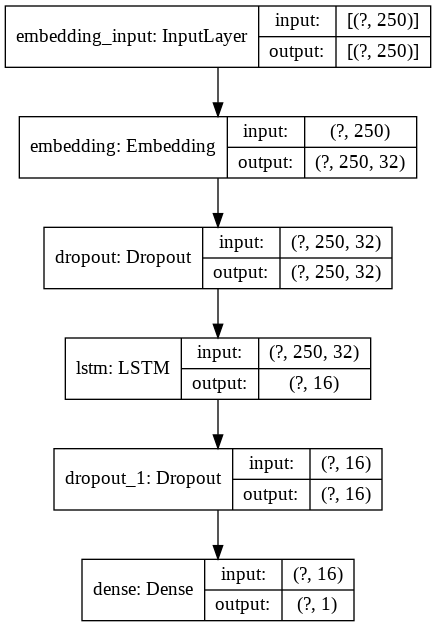

In [55]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Train

In [56]:
print(type(x_train_final["retweet_count"]))
print(type(train_padded))
x_train = np.array(train_padded)
y_train = np.array(x_train_final["retweet_count"])
print(type(x_train))
print(type(y_train))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [59]:
# Train the LSTM on the training data
history = model.fit(

    # Training data : features (tweets) and labels (number of tweets)
    x_train, y_train,
                    
    # Number of samples to work through before updating the 
    # internal model parameters via back propagation. The 
    # higher the batch, the more memory you need.
    batch_size=128, 

    # An epoch is an iteration over the entire training data.
    epochs=3, 
    
    # The model will set apart his fraction of the training 
    # data, will not train on it, and will evaluate the loss
    # and any model metrics on this data at the end of 
    # each epoch.
    validation_split=0.2,
    
    verbose=1
) 

Epoch 1/3
1519/1519 [==============================] - 161s 106ms/step - loss: 4.1765 - mean_absolute_error: 395.8513 - val_loss: 3.9139 - val_mean_absolute_error: 432.1815
Epoch 2/3
1519/1519 [==============================] - 159s 105ms/step - loss: 3.9706 - mean_absolute_error: 396.2297 - val_loss: 3.9142 - val_mean_absolute_error: 432.2213
Epoch 3/3
1519/1519 [==============================] - 160s 105ms/step - loss: 3.9693 - mean_absolute_error: 396.2399 - val_loss: 3.9141 - val_mean_absolute_error: 432.2144


# Evaluate model with test data and view results

# View some incorrect predictions

# Run your own text against the trained model